# Importing Datasets


In [2]:
import pandas as pd  # For data handling
import numpy as np  # For numerical operations
import networkx as nx  # For graph algorithms
import ast  # To safely parse edge list strings into Python lists
import matplotlib.pyplot as plt  # For plotting
import seaborn as sns  # For advanced plots
from sklearn.model_selection import GroupKFold, GridSearchCV  # Grouped cross-validation and hyperparameter tuning
from sklearn.preprocessing import MinMaxScaler
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from sklearn.metrics import accuracy_score
import networkx as nx
import numpy as np
from scipy import stats
import community as community_louvain
import math
from collections import Counter

In [3]:
# 1. Load datasets
train_df = pd.read_csv('train.csv')  # Load training data
test_df = pd.read_csv('test.csv')  # Load test data

# Initial Data Exploration

In [4]:

print(train_df.head(10))  # Show first few rows


   language  sentence   n                                           edgelist  \
0  Japanese         2  23  [(6, 4), (2, 6), (2, 23), (20, 2), (15, 20), (...   
1  Japanese         5  18  [(8, 9), (14, 8), (4, 14), (5, 4), (1, 2), (6,...   
2  Japanese         8  33  [(2, 10), (2, 14), (4, 2), (16, 4), (6, 16), (...   
3  Japanese        11  30  [(30, 1), (14, 24), (21, 14), (3, 21), (7, 3),...   
4  Japanese        12  19  [(19, 13), (16, 19), (2, 16), (4, 10), (4, 15)...   
5  Japanese        14  29  [(23, 29), (18, 23), (28, 18), (28, 12), (28, ...   
6  Japanese        16  19  [(19, 7), (14, 19), (16, 8), (15, 16), (13, 15...   
7  Japanese        21  19  [(9, 10), (14, 9), (18, 14), (7, 8), (16, 7), ...   
8  Japanese        25  19  [(11, 6), (18, 11), (13, 5), (18, 13), (10, 8)...   
9  Japanese        26  23  [(8, 23), (17, 8), (7, 17), (6, 5), (19, 6), (...   

   root  
0    10  
1    10  
2     3  
3    30  
4    11  
5     6  
6    14  
7    18  
8     7  
9     3  


In [5]:
print(train_df.describe())  # Summary statistics


           sentence             n          root
count  10500.000000  10500.000000  10500.000000
mean     494.778000     18.807524      9.844476
std      290.256632      8.190593      7.207740
min        2.000000      3.000000      1.000000
25%      233.500000     13.000000      4.000000
50%      483.000000     18.000000      8.000000
75%      742.250000     23.000000     14.000000
max      995.000000     70.000000     68.000000


In [6]:
print(train_df['language'].value_counts())  # Check language distribution

language
Japanese      500
German        500
Arabic        500
Portuguese    500
Chinese       500
Czech         500
Turkish       500
Thai          500
Polish        500
Korean        500
Icelandic     500
Finnish       500
Spanish       500
Swedish       500
Indonesian    500
Italian       500
French        500
Hindi         500
English       500
Galician      500
Russian       500
Name: count, dtype: int64


In [7]:
train_df.isna().sum()  # Check for missing values

language    0
sentence    0
n           0
edgelist    0
root        0
dtype: int64

# Visualization: Sentence lengths

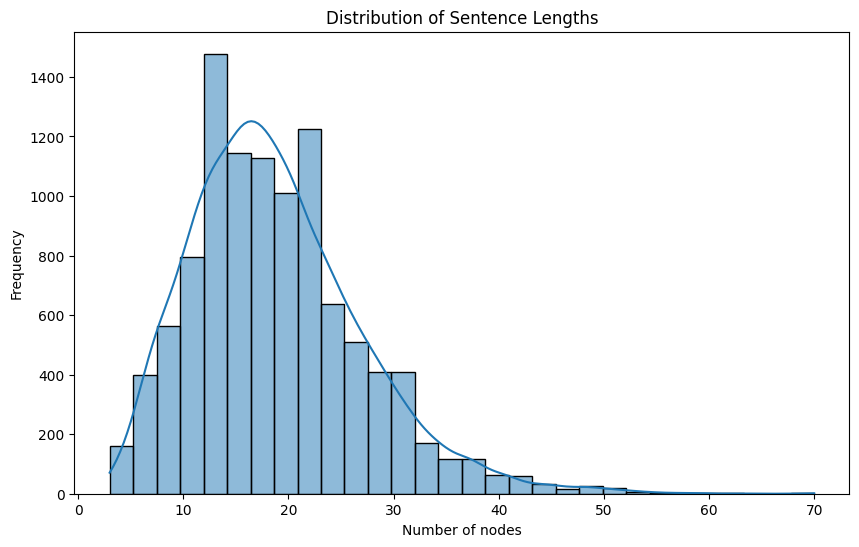

In [8]:

plt.figure(figsize=(10,6))
sns.histplot(train_df['n'], bins=30, kde=True)
plt.title('Distribution of Sentence Lengths')
plt.xlabel('Number of nodes')
plt.ylabel('Frequency')
plt.show()

# Data preprocessing

In [ ]:


def compute_expanded_features(edges):
    """Compute an expanded set of graph metrics for each node in the graph."""
    G = nx.Graph()
    G.add_edges_from(edges)
    
    # Get all nodes
    nodes = list(G.nodes())
    
    # Initialize feature dictionary
    features = {node: {} for node in nodes}
    
    # 1. CENTRALITY MEASURES
    # Basic centrality measures
    degree_cent = nx.degree_centrality(G)
    harmonic_cent = nx.harmonic_centrality(G)
    betweenness_cent = nx.betweenness_centrality(G)
    pagerank = nx.pagerank(G, alpha=0.85)
    katz_cent = nx.katz_centrality_numpy(G, alpha=0.1)
    load_cent = nx.load_centrality(G)
    closeness_cent = nx.closeness_centrality(G)
    
    # Additional centrality measures
    eigenvector_cent = nx.eigenvector_centrality_numpy(G)
    information_cent = nx.information_centrality(G) if nx.is_connected(G) else {n: 0 for n in nodes}
    
    # Calculate second-order centrality (centrality of neighbors)
    second_order_degree = {}
    second_order_betweenness = {}
    second_order_pagerank = {}
    
    for node in nodes:
        neighbors = list(G.neighbors(node))
        if neighbors:
            second_order_degree[node] = np.mean([degree_cent[n] for n in neighbors])
            second_order_betweenness[node] = np.mean([betweenness_cent[n] for n in neighbors])
            second_order_pagerank[node] = np.mean([pagerank[n] for n in neighbors])
        else:
            second_order_degree[node] = 0
            second_order_betweenness[node] = 0
            second_order_pagerank[node] = 0
    
    # 2. LOCAL STRUCTURE MEASURES
    # Clustering and triangles
    clustering = nx.clustering(G)
    triangles = nx.triangles(G)
    square_clustering = nx.square_clustering(G)
    
    # Local efficiency
    local_efficiency = {}
    for node in nodes:
        neighbors = list(G.neighbors(node))
        if len(neighbors) > 1:
            subgraph = G.subgraph(neighbors)
            local_efficiency[node] = nx.global_efficiency(subgraph)
        else:
            local_efficiency[node] = 0
    
    # 3. NEIGHBORHOOD METRICS
    # Neighborhood sizes at different depths
    neighborhood_size_2 = {}
    neighborhood_size_3 = {}
    for node in nodes:
        # Get all nodes within distance 2
        dist_2_nodes = set()
        for n in G.neighbors(node):
            dist_2_nodes.update(G.neighbors(n))
        dist_2_nodes.discard(node)  # Remove the original node
        neighborhood_size_2[node] = len(dist_2_nodes)
        
        # Get all nodes within distance 3
        dist_3_nodes = set()
        for n in dist_2_nodes:
            dist_3_nodes.update(G.neighbors(n))
        dist_3_nodes.discard(node)  # Remove the original node
        dist_3_nodes -= dist_2_nodes  # Remove nodes already counted in distance 2
        neighborhood_size_3[node] = len(dist_3_nodes)
    
    # Average neighbor degree and weighted variants
    avg_neighbor_deg = nx.average_neighbor_degree(G)
    
    # Neighbor degree statistics
    neighbor_degree_stats = {}
    for node in nodes:
        neighbor_degrees = [G.degree(n) for n in G.neighbors(node)] if G.degree(node) > 0 else [0]
        if neighbor_degrees:
            neighbor_degree_stats[node] = {
                'min': min(neighbor_degrees, default=0),
                'max': max(neighbor_degrees, default=0),
                'median': np.median(neighbor_degrees),
                'std': np.std(neighbor_degrees) if len(neighbor_degrees) > 1 else 0,
                'skew': stats.skew(neighbor_degrees) if len(neighbor_degrees) > 2 else 0,
                'kurtosis': stats.kurtosis(neighbor_degrees) if len(neighbor_degrees) > 3 else 0
            }
        else:
            neighbor_degree_stats[node] = {
                'min': 0, 'max': 0, 'median': 0, 'std': 0, 'skew': 0, 'kurtosis': 0
            }
    
    # 4. PATH-BASED METRICS
    # Eccentricity and related measures
    if nx.is_connected(G):
        eccentricity = nx.eccentricity(G)
        diameter = nx.diameter(G)
        radius = nx.radius(G)
        center = nx.center(G)
        periphery = nx.periphery(G)
        
        # Is node in center or periphery
        is_center = {node: 1 if node in center else 0 for node in nodes}
        is_periphery = {node: 1 if node in periphery else 0 for node in nodes}
    else:
        largest_cc = max(nx.connected_components(G), key=len)
        subgraph = G.subgraph(largest_cc)
        
        # Default values for nodes not in largest component
        eccentricity = {node: 0 for node in nodes}
        is_center = {node: 0 for node in nodes}
        is_periphery = {node: 0 for node in nodes}
        
        # Calculate for nodes in the largest component
        subgraph_eccentricity = nx.eccentricity(subgraph)
        subgraph_center = nx.center(subgraph)
        subgraph_periphery = nx.periphery(subgraph)
        
        for node in largest_cc:
            eccentricity[node] = subgraph_eccentricity[node]
            is_center[node] = 1 if node in subgraph_center else 0
            is_periphery[node] = 1 if node in subgraph_periphery else 0
    
    # Average shortest path length to all other nodes
    avg_shortest_path = {}
    for node in nodes:
        path_lengths = []
        for target in nodes:
            if node != target:
                try:
                    path_lengths.append(nx.shortest_path_length(G, node, target))
                except nx.NetworkXNoPath:
                    # If no path exists, can use infinity or a large value
                    # Here we'll use the node count as a penalty
                    path_lengths.append(len(nodes))
        avg_shortest_path[node] = np.mean(path_lengths) if path_lengths else 0
    
    # 5. COMMUNITY STRUCTURE
    # Community detection using Louvain method
    partition = community_louvain.best_partition(G)
    
    # Count nodes in each community
    community_sizes = Counter(partition.values())
    
    # Community-based features
    community_features = {}
    for node in nodes:
        if node in partition:
            community_id = partition[node]
            community_size = community_sizes[community_id]
            
            # Calculate ratio of connections within vs outside community
            node_degree = G.degree(node)
            internal_connections = sum(1 for neighbor in G.neighbors(node) 
                                       if neighbor in partition and partition[neighbor] == community_id)
            
            if node_degree > 0:
                internal_connection_ratio = internal_connections / node_degree
            else:
                internal_connection_ratio = 0
                
            community_features[node] = {
                'community_id': community_id,
                'community_size': community_size,
                'internal_connection_ratio': internal_connection_ratio
            }
        else:
            community_features[node] = {
                'community_id': -1,
                'community_size': 1,
                'internal_connection_ratio': 0
            }
    
    # 6. TOPOLOGICAL FEATURES
    # Core number (k-core decomposition)
    core_numbers = nx.core_number(G)
    
    # Voterank (influential nodes based on voting)
    voterank_scores = {}
    max_voterank = min(20, len(nodes))  # Limit computation
    voterank_nodes = nx.voterank(G, max_voterank)
    for i, node in enumerate(voterank_nodes):
        voterank_scores[node] = max_voterank - i
    
    for node in nodes:
        if node not in voterank_scores:
            voterank_scores[node] = 0
    
    # 7. SPECTRAL FEATURES
    # Compute Laplacian eigenvalues for the graph
    L = nx.normalized_laplacian_matrix(G).todense()
    try:
        eigenvalues = np.linalg.eigvalsh(L)
        algebraic_connectivity = eigenvalues[1] if len(eigenvalues) > 1 else 0
        spectral_gap = eigenvalues[1] - eigenvalues[0] if len(eigenvalues) > 1 else 0
    except:
        algebraic_connectivity = 0
        spectral_gap = 0
    
    # 8. CUSTOM FEATURES
    # Distance to highest degree node
    max_degree_node = max(degree_cent, key=degree_cent.get)
    dist_to_max_degree = {}
    for node in nodes:
        if node == max_degree_node:
            dist_to_max_degree[node] = 0
        else:
            try:
                dist_to_max_degree[node] = nx.shortest_path_length(G, node, max_degree_node)
            except nx.NetworkXNoPath:
                dist_to_max_degree[node] = len(nodes)  # No path exists
    
    # Relative position features
    degree_rank = {}
    betweenness_rank = {}
    pagerank_rank = {}
    
    sorted_degree = sorted([(node, val) for node, val in degree_cent.items()], 
                            key=lambda x: x[1], reverse=True)
    sorted_betweenness = sorted([(node, val) for node, val in betweenness_cent.items()], 
                                key=lambda x: x[1], reverse=True)
    sorted_pagerank = sorted([(node, val) for node, val in pagerank.items()], 
                            key=lambda x: x[1], reverse=True)
    
    for i, (node, _) in enumerate(sorted_degree):
        degree_rank[node] = i + 1
    
    for i, (node, _) in enumerate(sorted_betweenness):
        betweenness_rank[node] = i + 1
    
    for i, (node, _) in enumerate(sorted_pagerank):
        pagerank_rank[node] = i + 1
    
    # Calculate percentiles
    degree_percentile = {}
    betweenness_percentile = {}
    pagerank_percentile = {}
    
    n_nodes = len(nodes)
    for node in nodes:
        degree_percentile[node] = (n_nodes - degree_rank[node] + 1) / n_nodes * 100
        betweenness_percentile[node] = (n_nodes - betweenness_rank[node] + 1) / n_nodes * 100
        pagerank_percentile[node] = (n_nodes - pagerank_rank[node] + 1) / n_nodes * 100
    
    # 9. GRAPH-LEVEL CONTEXT
    # Global graph properties (same for all nodes)
    global_features = {
        'graph_density': nx.density(G),
        'graph_transitivity': nx.transitivity(G),
        'graph_num_nodes': len(nodes),
        'graph_num_edges': G.number_of_edges(),
        'graph_avg_degree': 2 * G.number_of_edges() / len(nodes) if len(nodes) > 0 else 0,
        'graph_max_degree': max([G.degree(n) for n in nodes], default=0)
    }
    
    # 10. COMPILE ALL FEATURES
    for node in nodes:
        # Basic centrality measures
        features[node]['degree_cent'] = degree_cent[node]
        features[node]['harmonic_cent'] = harmonic_cent[node]
        features[node]['betweenness_cent'] = betweenness_cent[node]
        features[node]['pagerank'] = pagerank[node]
        features[node]['katz_cent'] = katz_cent[node]
        features[node]['load_cent'] = load_cent[node]
        features[node]['closeness_cent'] = closeness_cent[node]
        features[node]['eigenvector_cent'] = eigenvector_cent[node]
        features[node]['information_cent'] = information_cent[node]
        
        # Second-order centrality
        features[node]['second_order_degree'] = second_order_degree[node]
        features[node]['second_order_betweenness'] = second_order_betweenness[node]
        features[node]['second_order_pagerank'] = second_order_pagerank[node]
        
        # Local structure
        features[node]['clustering_coef'] = clustering[node]
        features[node]['triangles'] = triangles[node]
        features[node]['square_clustering'] = square_clustering[node]
        features[node]['local_efficiency'] = local_efficiency[node]
        
        # Neighborhood metrics
        features[node]['neighborhood_size_2'] = neighborhood_size_2[node]
        features[node]['neighborhood_size_3'] = neighborhood_size_3[node]
        features[node]['avg_neighbor_deg'] = avg_neighbor_deg[node]
        features[node]['min_neighbor_deg'] = neighbor_degree_stats[node]['min']
        features[node]['max_neighbor_deg'] = neighbor_degree_stats[node]['max']
        features[node]['median_neighbor_deg'] = neighbor_degree_stats[node]['median']
        features[node]['std_neighbor_deg'] = neighbor_degree_stats[node]['std']
        features[node]['skew_neighbor_deg'] = neighbor_degree_stats[node]['skew']
        features[node]['kurtosis_neighbor_deg'] = neighbor_degree_stats[node]['kurtosis']
        
        # Path-based metrics
        features[node]['eccentricity'] = eccentricity[node]
        features[node]['is_center'] = is_center[node]
        features[node]['is_periphery'] = is_periphery[node]
        features[node]['avg_shortest_path'] = avg_shortest_path[node]
        
        # Community structure
        features[node]['community_id'] = community_features[node]['community_id']
        features[node]['community_size'] = community_features[node]['community_size']
        features[node]['internal_connection_ratio'] = community_features[node]['internal_connection_ratio']
        
        # Topological features
        features[node]['core_number'] = core_numbers[node]
        features[node]['voterank_score'] = voterank_scores[node]
        
        # Relative position features
        features[node]['degree_rank'] = degree_rank[node]
        features[node]['betweenness_rank'] = betweenness_rank[node]
        features[node]['pagerank_rank'] = pagerank_rank[node]
        features[node]['degree_percentile'] = degree_percentile[node]
        features[node]['betweenness_percentile'] = betweenness_percentile[node]
        features[node]['pagerank_percentile'] = pagerank_percentile[node]
        features[node]['dist_to_max_degree'] = dist_to_max_degree[node]
        
        # Graph-level context
        for key, value in global_features.items():
            features[node][key] = value
        
        # Network ratios and derived metrics
        if global_features['graph_max_degree'] > 0:
            features[node]['degree_ratio_to_max'] = G.degree(node) / global_features['graph_max_degree']
        else:
            features[node]['degree_ratio_to_max'] = 0
            
        features[node]['degree_centrality_to_density_ratio'] = degree_cent[node] / global_features['graph_density'] if global_features['graph_density'] > 0 else 0
        
        # Additional derived features
        features[node]['harmonic_to_degree_ratio'] = harmonic_cent[node] / degree_cent[node] if degree_cent[node] > 0 else 0
        features[node]['betweenness_to_degree_ratio'] = betweenness_cent[node] / degree_cent[node] if degree_cent[node] > 0 else 0
        features[node]['pagerank_to_degree_ratio'] = pagerank[node] / degree_cent[node] if degree_cent[node] > 0 else 0
        
        # Local assortativity: correlation between node degree and neighbor degrees
        neighbors = list(G.neighbors(node))
        if neighbors:
            node_degree = G.degree(node)
            neighbor_degrees = [G.degree(n) for n in neighbors]
            try:
                if len(neighbor_degrees) > 1 and np.std(neighbor_degrees) > 0:
                    features[node]['local_assortativity'] = np.corrcoef(
                        [node_degree] * len(neighbors), neighbor_degrees)[0, 1]
                else:
                    features[node]['local_assortativity'] = 0
            except:
                features[node]['local_assortativity'] = 0
        else:
            features[node]['local_assortativity'] = 0
    
    # 11. ADDITIONAL DERIVED FEATURES
    for node in nodes:
        # Create combination features
        features[node]['degree_betweenness_product'] = features[node]['degree_cent'] * features[node]['betweenness_cent']
        features[node]['pagerank_clustering_product'] = features[node]['pagerank'] * features[node]['clustering_coef']
        features[node]['centrality_harmonic_mean'] = stats.hmean([
            features[node]['degree_cent'] + 1e-8,
            features[node]['betweenness_cent'] + 1e-8,
            features[node]['pagerank'] + 1e-8
        ])
        
        # Log transformations of skewed metrics
        features[node]['log_betweenness'] = np.log1p(features[node]['betweenness_cent'])
        features[node]['log_triangles'] = np.log1p(features[node]['triangles'])
        
        # More complex derived metrics
        features[node]['clustering_degree_ratio'] = features[node]['clustering_coef'] / features[node]['degree_cent'] if features[node]['degree_cent'] > 0 else 0
        features[node]['betweenness_eigenvector_ratio'] = features[node]['betweenness_cent'] / features[node]['eigenvector_cent'] if features[node]['eigenvector_cent'] > 0 else 0
    
    return features

# Example usage
def build_expanded_training_data(train_df):
    train_rows = []
    for idx, row in train_df.iterrows():
        edges = ast.literal_eval(row['edgelist'])
        
        # Compute expanded features for each node
        all_features = compute_expanded_features(edges)
        
        root = row['root']
        for node, feats in all_features.items():
            node_data = {
                'language': row['language'],
                'sentence': row['sentence'],
                'node': node,
                'n_nodes': row['n'],
                'target': 1 if node == root else 0
            }
            
            # Add all the features
            for feature_name, feature_value in feats.items():
                node_data[feature_name] = feature_value
                
            train_rows.append(node_data)
    
    return train_rows




In [12]:
# Usage:
train_rows = build_expanded_training_data(train_df)
expanded_train = pd.DataFrame(train_rows)
expanded_train

/var/folders/t2/km8wh4ms46vbb2wjtr90_gn00000gn/T/ipykernel_95704/1543172991.py:91: RuntimeWarning: Precision loss occurred in moment calculation due to catastrophic cancellation. This occurs when the data are nearly identical. Results may be unreliable.
  'skew': stats.skew(neighbor_degrees) if len(neighbor_degrees) > 2 else 0,
/Users/sarasaad/Documents/BDMA /UPC/ML/Project/tree-root-prediction/.venv/lib/python3.13/site-packages/numpy/lib/_function_base_impl.py:3045: RuntimeWarning: invalid value encountered in divide
  c /= stddev[:, None]
/Users/sarasaad/Documents/BDMA /UPC/ML/Project/tree-root-prediction/.venv/lib/python3.13/site-packages/numpy/lib/_function_base_impl.py:3046: RuntimeWarning: invalid value encountered in divide
  c /= stddev[None, :]
/var/folders/t2/km8wh4ms46vbb2wjtr90_gn00000gn/T/ipykernel_95704/1543172991.py:92: RuntimeWarning: Precision loss occurred in moment calculation due to catastrophic cancellation. This occurs when the data are nearly identical. Results m

,language,sentence,node,n_nodes,target,degree_cent,harmonic_cent,betweenness_cent,pagerank,katz_cent,...,betweenness_to_degree_ratio,pagerank_to_degree_ratio,local_assortativity,degree_betweenness_product,pagerank_clustering_product,centrality_harmonic_mean,log_betweenness,log_triangles,clustering_degree_ratio,betweenness_eigenvector_ratio
0,Japanese,2,6,23,0,0.090909,5.823846,0.090909,0.048565,0.209086,...,1.000000,0.534217,NaN,0.008264,0.0,7.043759e-02,0.087011,0.0,0.0,0.608067
1,Japanese,2,4,23,0,0.045455,4.561122,0.000000,0.027162,0.188298,...,0.000000,0.597554,0.0,0.000000,0.0,2.999998e-08,0.000000,0.0,0.0,0.000000
2,Japanese,2,2,23,0,0.136364,6.991703,0.255411,0.066901,0.228660,...,1.873016,0.490609,NaN,0.034829,0.0,1.145213e-01,0.227463,0.0,0.0,0.991095
3,Japanese,2,23,23,0,0.045455,5.157179,0.000000,0.025477,0.190256,...,0.000000,0.560504,0.0,0.000000,0.0,2.999998e-08,0.000000,0.0,0.0,0.000000
4,Japanese,2,20,23,0,0.090909,7.146825,0.311688,0.042552,0.213357,...,3.428571,0.468071,0.0,0.028335,0.0,7.955653e-02,0.271315,0.0,0.0,1.057609
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
197474,Russian,995,19,19,0,0.055556,5.005159,0.000000,0.032147,0.205491,...,0.000000,0.578643,0.0,0.000000,0.0,2.999999e-08,0.000000,0.0,0.0,0.000000
197475,Russian,995,1,19,0,0.055556,6.034524,0.000000,0.029739,0.211939,...,0.000000,0.535310,0.0,0.000000,0.0,2.999998e-08,0.000000,0.0,0.0,0.000000
197476,Russian,995,14,19,0,0.055556,6.034524,0.000000,0.029739,0.211939,...,0.000000,0.535310,0.0,0.000000,0.0,2.999998e-08,0.000000,0.0,0.0,0.000000
197477,Russian,995,5,19,0,0.111111,6.701190,0.111111,0.057065,0.232488,...,1.000000,0.513582,NaN,0.012346,0.0,8.444999e-02,0.105361,0.0,0.0,0.411256


In [18]:
import pandas as pd
import numpy as np

def analyze_feature_quality(df):
    """
    Analyzes each feature in the dataframe to identify empty, NaN, or problematic values.
    
    Args:
        df: DataFrame containing the features
        
    Returns:
        Dictionary with analysis results
    """
    results = {}
    
    # Get all columns except categorical/identifier columns
    feature_cols = [col for col in df.columns if col not in ['language', 'sentence', 'node', 'target']]
    
    print(f"Total features to analyze: {len(feature_cols)}")
    
    for col in feature_cols:
        # Check for NaN values
        nan_count = df[col].isna().sum()
        nan_percent = (nan_count / len(df)) * 100
        
        # Check for infinity values
        inf_count = np.isinf(df[col].replace([np.inf, -np.inf], np.nan)).sum()
        inf_percent = (inf_count / len(df)) * 100
        
        # Check for zero values
        zero_count = (df[col] == 0).sum()
        zero_percent = (zero_count / len(df)) * 100
        
        # Check for negative values (might be problematic for certain metrics)
        neg_count = (df[col] < 0).sum() if df[col].dtype in [np.int64, np.float64] else 0
        neg_percent = (neg_count / len(df)) * 100 if df[col].dtype in [np.int64, np.float64] else 0
        
        # Check for constants
        is_constant = df[col].nunique() <= 1
        
        # Check for variance too low
        variance = df[col].var() if df[col].dtype in [np.int64, np.float64] else None
        low_variance = variance is not None and variance < 0.0001
        
        results[col] = {
            'nan_count': nan_count,
            'nan_percent': nan_percent,
            'inf_count': inf_count,
            'inf_percent': inf_percent,
            'zero_count': zero_count,
            'zero_percent': zero_percent,
            'neg_count': neg_count,
            'neg_percent': neg_percent,
            'is_constant': is_constant,
            'variance': variance,
            'low_variance': low_variance,
            'dtype': str(df[col].dtype)
        }
    
    return results

def feature_quality_report(df):
    """
    Generates a human-readable report on feature quality.
    
    Args:
        df: DataFrame containing the features
        
    Returns:
        String containing the report
    """
    analysis = analyze_feature_quality(df)
    
    # Sort features by problematic metrics
    features_by_nan = sorted([(col, data['nan_percent']) for col, data in analysis.items()], 
                             key=lambda x: x[1], reverse=True)
    
    features_by_inf = sorted([(col, data['inf_percent']) for col, data in analysis.items()], 
                            key=lambda x: x[1], reverse=True)
    
    features_by_const = [(col, data) for col, data in analysis.items() if data['is_constant']]
    
    features_by_low_var = [(col, data) for col, data in analysis.items() 
                          if not data['is_constant'] and data['low_variance']]
    
    # Generate report
    report = "Feature Quality Analysis Report\n"
    report += "===========================\n\n"
    
    report += f"Total Features: {len(analysis)}\n\n"
    
    # Report on NaN values
    report += "Features with NaN values (top 10):\n"
    for col, percent in features_by_nan[:10]:
        if percent > 0:
            report += f"  {col}: {percent:.2f}% NaN ({analysis[col]['nan_count']} values)\n"
    report += "\n"
    
    # Report on Inf values
    report += "Features with Inf values (top 10):\n"
    for col, percent in features_by_inf[:10]:
        if percent > 0:
            report += f"  {col}: {percent:.2f}% Inf ({analysis[col]['inf_count']} values)\n"
    report += "\n"
    
    # Report on constant features
    report += "Constant features (no variation):\n"
    for col, data in features_by_const:
        report += f"  {col}: constant value\n"
    report += "\n"
    
    # Report on low variance features
    report += "Features with very low variance:\n"
    for col, data in features_by_low_var[:10]:
        report += f"  {col}: variance = {data['variance']:.8f}\n"
    report += "\n"
    
    # Report on features with high zero percentage
    high_zero_features = [(col, data['zero_percent']) for col, data in analysis.items() 
                        if data['zero_percent'] > 90]
    high_zero_features.sort(key=lambda x: x[1], reverse=True)
    
    report += "Features with >90% zero values:\n"
    for col, percent in high_zero_features:
        report += f"  {col}: {percent:.2f}% zeros\n"
    report += "\n"
    
    # Report on potentially problematic feature pairs
    report += "Recommendations:\n"
    
    # Check for NaN values
    if any(data['nan_percent'] > 0 for data in analysis.values()):
        report += "- Handle NaN values: Some features contain NaN values that should be filled or removed\n"
    
    # Check for infinity values
    if any(data['inf_percent'] > 0 for data in analysis.values()):
        report += "- Handle infinity values: Some features contain Inf values that should be replaced\n"
    
    # Check for constants
    if features_by_const:
        report += "- Remove constant features: These features provide no information for modeling\n"
    
    # Check for low variance
    if features_by_low_var:
        report += "- Consider removing low variance features: These features may not provide much signal\n"
    
    return report

def fix_problematic_features(df, replace_nan=True, replace_inf=True, drop_constant=True):
    """
    Fixes common issues in the feature dataset.
    
    Args:
        df: DataFrame containing the features
        replace_nan: Whether to replace NaN values (with 0)
        replace_inf: Whether to replace infinity values
        drop_constant: Whether to drop constant columns
        
    Returns:
        Cleaned DataFrame
    """
    # Make a copy to avoid modifying the original
    df_clean = df.copy()
    
    # Get feature columns (non-identifier columns)
    feature_cols = [col for col in df.columns if col not in ['language', 'sentence', 'node', 'target']]
    
    # Replace NaN values with 0
    if replace_nan:
        df_clean[feature_cols] = df_clean[feature_cols].fillna(0)
    
    # Replace infinity values with large values
    if replace_inf:
        for col in feature_cols:
            if df_clean[col].dtype in [np.float64, np.int64]:
                df_clean[col] = df_clean[col].replace([np.inf, -np.inf], 0)
    
    # Drop constant columns
    if drop_constant:
        constant_cols = [col for col in feature_cols if df_clean[col].nunique() <= 1]
        if constant_cols:
            print(f"Dropping {len(constant_cols)} constant columns")
            df_clean = df_clean.drop(columns=constant_cols)
    
    return df_clean

# Example usage:
analysis_report = feature_quality_report(expanded_train)
print(analysis_report)
# 
# # Fix issues in the dataset
cleaned_df = fix_problematic_features(expanded_train)
# 
# # Verify the cleaning worked
print(feature_quality_report(cleaned_df))

Total features to analyze: 61
Feature Quality Analysis Report

Total Features: 61

Features with NaN values (top 10):
  local_assortativity: 49.67% NaN (98096 values)
  skew_neighbor_deg: 0.97% NaN (1907 values)
  kurtosis_neighbor_deg: 0.16% NaN (310 values)

Features with Inf values (top 10):

Constant features (no variation):
  clustering_coef: constant value
  triangles: constant value
  square_clustering: constant value
  local_efficiency: constant value
  core_number: constant value
  graph_transitivity: constant value
  local_assortativity: constant value
  pagerank_clustering_product: constant value
  log_triangles: constant value
  clustering_degree_ratio: constant value

Features with very low variance:

Features with >90% zero values:
  clustering_coef: 100.00% zeros
  triangles: 100.00% zeros
  square_clustering: 100.00% zeros
  local_efficiency: 100.00% zeros
  graph_transitivity: 100.00% zeros
  pagerank_clustering_product: 100.00% zeros
  log_triangles: 100.00% zeros
  c

In [ ]:
cleaned_df

,language,sentence,node,n_nodes,target,degree_cent,harmonic_cent,betweenness_cent,pagerank,katz_cent,...,graph_max_degree,degree_ratio_to_max,degree_centrality_to_density_ratio,harmonic_to_degree_ratio,betweenness_to_degree_ratio,pagerank_to_degree_ratio,degree_betweenness_product,centrality_harmonic_mean,log_betweenness,betweenness_eigenvector_ratio
0,Japanese,2,6,23,0,0.090909,5.823846,0.090909,0.048565,0.209086,...,3,0.666667,1.045455,64.062302,1.000000,0.534217,0.008264,7.043759e-02,0.087011,0.608067
1,Japanese,2,4,23,0,0.045455,4.561122,0.000000,0.027162,0.188298,...,3,0.333333,0.522727,100.344689,0.000000,0.597554,0.000000,2.999998e-08,0.000000,0.000000
2,Japanese,2,2,23,0,0.136364,6.991703,0.255411,0.066901,0.228660,...,3,1.000000,1.568182,51.272487,1.873016,0.490609,0.034829,1.145213e-01,0.227463,0.991095
3,Japanese,2,23,23,0,0.045455,5.157179,0.000000,0.025477,0.190256,...,3,0.333333,0.522727,113.457937,0.000000,0.560504,0.000000,2.999998e-08,0.000000,0.000000
4,Japanese,2,20,23,0,0.090909,7.146825,0.311688,0.042552,0.213357,...,3,0.666667,1.045455,78.615079,3.428571,0.468071,0.028335,7.955653e-02,0.271315,1.057609
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
197474,Russian,995,19,19,0,0.055556,5.005159,0.000000,0.032147,0.205491,...,5,0.200000,0.527778,90.092857,0.000000,0.578643,0.000000,2.999999e-08,0.000000,0.000000
197475,Russian,995,1,19,0,0.055556,6.034524,0.000000,0.029739,0.211939,...,5,0.200000,0.527778,108.621429,0.000000,0.535310,0.000000,2.999998e-08,0.000000,0.000000
197476,Russian,995,14,19,0,0.055556,6.034524,0.000000,0.029739,0.211939,...,5,0.200000,0.527778,108.621429,0.000000,0.535310,0.000000,2.999998e-08,0.000000,0.000000
197477,Russian,995,5,19,0,0.111111,6.701190,0.111111,0.057065,0.232488,...,5,0.400000,1.055556,60.310714,1.000000,0.513582,0.012346,8.444999e-02,0.105361,0.411256


In [21]:
expanded_train = cleaned_df

In [25]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import MinMaxScaler

def normalize_features(df, exclude_cols=None):
    """
    Normalize all numerical features per (language, sentence) group using MinMaxScaler.
    
    Args:
        df: DataFrame containing features to normalize
        exclude_cols: List of columns to exclude from normalization
        
    Returns:
        DataFrame with normalized features
    """
    if exclude_cols is None:
        exclude_cols = ['language', 'sentence', 'node', 'target', 'community_id', 'n_nodes']
    
    # Make a copy to avoid modifying the original
    df_normalized = df.copy()
    
    # Get all numeric columns to normalize
    numeric_cols = df.select_dtypes(include=['int64', 'float64']).columns.tolist()
    
    # Filter out excluded columns
    normalize_cols = [col for col in numeric_cols if col not in exclude_cols]
    print(f"Normalizing {len(normalize_cols)} features")
    
    # Group by language and sentence, then normalize each group independently
    for (lang, sent), group in df.groupby(['language', 'sentence']):
        # For each group, normalize all numerical features
        for col in normalize_cols:
            # Skip columns with all same values (can't normalize)
            if group[col].nunique() <= 1:
                continue
                
            # Handle potential NaN values
            if group[col].isna().any():
                # Fill NaN with 0 before normalizing
                group_values = group[col].fillna(0).values.reshape(-1, 1)
            else:
                group_values = group[col].values.reshape(-1, 1)
                
            # Apply MinMaxScaler
            try:
                scaler = MinMaxScaler()
                normalized_values = scaler.fit_transform(group_values).flatten()
                
                # Update the normalized dataframe
                indices = group.index
                df_normalized.loc[indices, col] = normalized_values
            except Exception as e:
                print(f"Error normalizing {col} for {lang}, {sent}: {e}")
    
    return df_normalized

def batch_normalize_features(df, batch_size=100, exclude_cols=None):
    """
    Normalize all numerical features in batches to handle large dataframes.
    
    Args:
        df: DataFrame containing features to normalize
        batch_size: Number of (language, sentence) groups to process at once
        exclude_cols: List of columns to exclude from normalization
        
    Returns:
        DataFrame with normalized features
    """
    if exclude_cols is None:
        exclude_cols = ['language', 'sentence', 'node', 'target', 'community_id', 'n_nodes']
    
    # Make a copy to avoid modifying the original
    df_normalized = df.copy()
    
    # Get unique (language, sentence) combinations
    unique_groups = df[['language', 'sentence']].drop_duplicates()
    total_groups = len(unique_groups)
    print(f"Total groups to normalize: {total_groups}")
    
    # Process in batches
    for i in range(0, total_groups, batch_size):
        print(f"Processing batch {i//batch_size + 1}/{(total_groups-1)//batch_size + 1}")
        batch_groups = unique_groups.iloc[i:i+batch_size]
        
        # Create mask for the current batch
        mask = False
        for _, row in batch_groups.iterrows():
            lang, sent = row['language'], row['sentence']
            group_mask = (df['language'] == lang) & (df['sentence'] == sent)
            mask = mask | group_mask
        
        # Get the subset of data for the current batch
        batch_df = df[mask].copy()
        
        # Normalize the batch
        normalized_batch = normalize_features(batch_df, exclude_cols)
        
        # Update the normalized dataframe
        df_normalized.loc[mask] = normalized_batch
    
    return df_normalized

def smart_normalize_features(df):
    """
    Intelligently normalize features based on their characteristics.
    
    Args:
        df: DataFrame containing features to normalize
        
    Returns:
        DataFrame with normalized features
    """
    # Basic columns that shouldn't be normalized
    non_feature_cols = ['language', 'sentence', 'node', 'target', 'n_nodes', 'community_id']
    
    # Binary columns (0/1) shouldn't be normalized
    binary_cols = []
    for col in df.columns:
        if col in non_feature_cols:
            continue
        if set(df[col].dropna().unique()).issubset({0, 1}):
            binary_cols.append(col)
    
    print(f"Detected {len(binary_cols)} binary columns that won't be normalized")
    
    # ID or categorical columns shouldn't be normalized
    id_cols = []
    for col in df.columns:
        if col in non_feature_cols or col in binary_cols:
            continue
        # Check if column might be categorical
        if df[col].dtype == 'object' or (df[col].dtype.kind in 'if' and df[col].nunique() < 10):
            id_cols.append(col)
    
    print(f"Detected {len(id_cols)} potential ID/categorical columns that won't be normalized")
    
    # Columns to exclude from normalization
    exclude_cols = non_feature_cols + binary_cols + id_cols
    
    # Normalize the remaining features by group
    return batch_normalize_features(df, exclude_cols=exclude_cols)

# Example usage:
# Normalize all features in the expanded training data
# normalized_df = smart_normalize_features(expanded_train)

# You can also use the original approach you provided but with all numeric features:
def normalize_all_numeric_features(df):
    """
    Normalize all numeric features using your original approach
    """
    # Make a copy
    df_normalized = df.copy()
    
    # Get all numeric features (excluding the ones we don't want to normalize)
    exclude_cols = ['language', 'sentence', 'node', 'target', 'n_nodes', 'community_id']
    numeric_cols = df.select_dtypes(include=['int64', 'float64']).columns.tolist()
    features = [col for col in numeric_cols if col not in exclude_cols]
    
    print(f"Normalizing {len(features)} features")
    
    # Normalize each feature per (language, sentence) group
    df_normalized[features] = df_normalized.groupby(['language', 'sentence'])[features]\
        .transform(lambda x: MinMaxScaler().fit_transform(x.values.reshape(-1, 1)).flatten())
    
    return df_normalized

# Choose one of these approaches:
# normalized_df = smart_normalize_features(expanded_train_df)  # More robust, handles edge cases
normalized_df = normalize_all_numeric_features(expanded_train)  # Similar to your original approach

Normalizing 49 features


In [26]:
expanded_train = normalized_df

# Create a Train - Validation Set

In our dataset, each row represents a node within a graph, and each graph corresponds to a unique (language, sentence) pair. To ensure that the model evaluation is valid, we perform grouped splitting based on these identifiers.

If we randomly split individual rows into training and validation sets, nodes from the same graph could appear in both sets. This introduces data leakage, allowing the model to indirectly learn about the validation data during training. As a result, performance metrics would be over-optimistic and unreliable.

To prevent this, we group the data by language and sentence, ensuring that entire graphs remain in either the training or validation set, but never both. This approach preserves the structural independence of graphs across splits and results in a more realistic and fair evaluation of the model’s generalization capability.



In [27]:
from sklearn.model_selection import train_test_split

# Create a unique group identifier (optional but clean)
expanded_train['group'] = expanded_train['language'].astype(str) + '_' + expanded_train['sentence'].astype(str)

# Get unique groups
unique_groups = expanded_train['group'].unique()

# Split the groups
train_groups, val_groups = train_test_split(unique_groups, test_size=0.2, random_state=42)

# Select rows by group
train_df = expanded_train[expanded_train['group'].isin(train_groups)].reset_index(drop=True)
val_df = expanded_train[expanded_train['group'].isin(val_groups)].reset_index(drop=True)


## Imbalance handling



### Oversampling with RANDOMOVERSAMPLER


In [15]:
"""
from imblearn.over_sampling import RandomOverSampler
import pandas as pd

# Step 1: Separate features and target
X = train_df.drop(columns=['target', 'language', 'sentence', 'node','group'])  # Only numerical features
y = train_df['target']

# Save identifier columns to merge back later
id_cols = train_df[['language', 'sentence', 'node']].reset_index(drop=True)

# Step 2: Apply RandomOverSampler to only the minority class (target==1)
ros = RandomOverSampler(sampling_strategy='minority', random_state=42)
X_resampled, y_resampled = ros.fit_resample(X, y)

# Step 3: Reattach metadata
id_resampled = id_cols.iloc[ros.sample_indices_].reset_index(drop=True)
resampled_df = pd.concat([id_resampled, pd.DataFrame(X_resampled, columns=X.columns), pd.Series(y_resampled, name='target')], axis=1)
"""

"\nfrom imblearn.over_sampling import RandomOverSampler\nimport pandas as pd\n\n# Step 1: Separate features and target\nX = train_df.drop(columns=['target', 'language', 'sentence', 'node','group'])  # Only numerical features\ny = train_df['target']\n\n# Save identifier columns to merge back later\nid_cols = train_df[['language', 'sentence', 'node']].reset_index(drop=True)\n\n# Step 2: Apply RandomOverSampler to only the minority class (target==1)\nros = RandomOverSampler(sampling_strategy='minority', random_state=42)\nX_resampled, y_resampled = ros.fit_resample(X, y)\n\n# Step 3: Reattach metadata\nid_resampled = id_cols.iloc[ros.sample_indices_].reset_index(drop=True)\nresampled_df = pd.concat([id_resampled, pd.DataFrame(X_resampled, columns=X.columns), pd.Series(y_resampled, name='target')], axis=1)\n"

In [28]:
resampled_df = train_df

# Modeling


Will the sentences be treated as all sa

In [29]:
from sklearn.model_selection import GridSearchCV, GroupKFold
from sklearn.pipeline import Pipeline
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, make_scorer, classification_report

from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import (
    RandomForestClassifier, GradientBoostingClassifier, AdaBoostClassifier,
    ExtraTreesClassifier, BaggingClassifier
)
from sklearn.svm import SVC
from sklearn.naive_bayes import GaussianNB
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.discriminant_analysis import QuadraticDiscriminantAnalysis
from sklearn.calibration import CalibratedClassifierCV

from xgboost import XGBClassifier

import numpy as np
import pandas as pd

# === Define parameter grids ===
param_grids = {
    'Logistic Regression': {'model__C': [0.01, 0.1, 1, 10]},
    'Random Forest': {'model__n_estimators': [100, 200], 'model__max_depth': [None, 10, 20]},
    'XGBoost': {
        'model__learning_rate': [0.01, 0.05],
        'model__n_estimators': [100, 300],
        'model__max_depth': [4, 6],
        'model__subsample': [0.8],
        'model__colsample_bytree': [0.8]
    },
    'Decision Tree': {'model__max_depth': [None, 10, 20], 'model__min_samples_split': [2, 5, 10]},
    'KNN': {'model__n_neighbors': [3, 5, 7], 'model__weights': ['uniform', 'distance']},
    'Extra Trees': {'model__n_estimators': [100, 200], 'model__max_depth': [None, 10]},
    'Gradient Boosting': {'model__n_estimators': [100, 200], 'model__learning_rate': [0.05, 0.1], 'model__max_depth': [3, 5]},
    'AdaBoost': {'model__n_estimators': [50, 100], 'model__learning_rate': [0.5, 1.0]},
    'Naive Bayes': {},
    'MLP': {'model__hidden_layer_sizes': [(50,), (100,)], 'model__activation': ['relu', 'tanh'], 'model__alpha': [0.0001, 0.001]},
    'Bagging': {'model__n_estimators': [10, 50], 'model__max_samples': [0.8, 1.0]},
    'Calibrated SVM': CalibratedClassifierCV(estimator=SVC(probability=True, class_weight='balanced', random_state=42)),
    'QDA': {'model__reg_param': [0.0, 0.1, 0.5]}
}

# === Define models ===
model_classes = {
    'Logistic Regression': LogisticRegression(class_weight='balanced', max_iter=1000, random_state=42),
    'Random Forest': RandomForestClassifier(class_weight='balanced', random_state=42),
    'XGBoost': XGBClassifier(objective='binary:logistic', scale_pos_weight=30, subsample=0.8, colsample_bytree=0.8, random_state=42, eval_metric='logloss'),
    'Decision Tree': DecisionTreeClassifier(class_weight='balanced', random_state=42),
    'KNN': KNeighborsClassifier(),
    'Extra Trees': ExtraTreesClassifier(random_state=42),
    'Gradient Boosting': GradientBoostingClassifier(random_state=42),
    'AdaBoost': AdaBoostClassifier(random_state=42),
    'Naive Bayes': GaussianNB(),
    'MLP': MLPClassifier(max_iter=500, random_state=42),
    'Bagging': BaggingClassifier(random_state=42),
    'Calibrated SVM': {
    'model__estimator__C': [0.1, 1],
    'model__estimator__kernel': ['linear']
},
    'QDA': QuadraticDiscriminantAnalysis()
}

# === Scoring setup ===
scoring = {
    'accuracy': make_scorer(accuracy_score),
    'precision': make_scorer(precision_score, average='macro', zero_division=0),
    'recall': make_scorer(recall_score, average='macro', zero_division=0),
    'f1': make_scorer(f1_score, average='macro', zero_division=0)
}

# === Prepare your data ===
# Ensure `resampled_df`, `val_df`, and `features` are defined beforehand.
X_train = resampled_df[features + ['n_nodes']]
y_train = resampled_df['target']
groups_train = resampled_df['sentence']

X_val = val_df[features + ['n_nodes']]
y_val = val_df['target']

# === Cross-validation setup ===
gkf = GroupKFold(n_splits=5)

# === Run models ===
best_models = {}

for name, base_model in model_classes.items():
    print(f"\n {name}")
    pipe = Pipeline([('model', base_model)])
    param_grid = param_grids[name]

    grid = GridSearchCV(pipe, param_grid, cv=gkf, scoring='f1', n_jobs=-1, verbose=1)

    try:
        grid.fit(X_train, y_train, groups=groups_train)
        best_model = grid.best_estimator_
        best_models[name] = best_model

        print(f"   Best hyperparameters: {grid.best_params_}")

        y_pred_val = best_model.predict(X_val)

        print("   Validation Set Evaluation:")
        print(f"    Accuracy:  {accuracy_score(y_val, y_pred_val):.4f}")
        print(f"    Precision: {precision_score(y_val, y_pred_val, average='macro', zero_division=0):.4f}")
        print(f"    Recall:    {recall_score(y_val, y_pred_val, average='macro', zero_division=0):.4f}")
        print(f"    F1 Score:  {f1_score(y_val, y_pred_val, average='macro', zero_division=0):.4f}")
        print(f"    F1 Score:  {classification_report(y_val, y_pred_val, target_names=['Non-Root', 'Root'])}")

    except Exception as e:
        print(f"   Skipped {name} due to error: {e}")


NameError: name 'features' is not defined

In [30]:
  
# Run separate search for Random Forest to isolate best model
rf_pipe = Pipeline([('model', model_classes['Random Forest'])])
rf_grid = GridSearchCV(rf_pipe, param_grids['Random Forest'], cv=gkf, scoring='f1', n_jobs=-1)
rf_grid.fit(X_train, y_train, groups=groups_train)

best_rf_model = rf_grid.best_estimator_.named_steps['model']  # extract RandomForestClassifier from pipeline

# Get importances
importances = best_rf_model.feature_importances_

# Plot
plt.figure(figsize=(10, 6))
plt.barh(features + ['n_nodes'], importances)
plt.title('Feature Importance - Best Random Forest Model')
plt.xlabel('Importance')
plt.tight_layout()
plt.show()

NameError: name 'gkf' is not defined

In [31]:
# === Predicting for the test set using ensemble of best models ===
submission_rows = []
top_k = 3

for idx, row in test_df.iterrows():
    edges = ast.literal_eval(row['edgelist'])
    T = nx.from_edgelist(edges)
    centralities = compute_centralities(edges)

    test_nodes = []
    test_feats = []
    for node, feats in centralities.items():
        test_nodes.append(node)
        test_feats.append(feats)

    test_feats_df = pd.DataFrame(test_feats, columns=features)
    test_feats_df['n_nodes'] = row['n']

    probs = np.zeros(len(test_feats_df))

    # Use the trained best models from the grid search
    for model in best_models.values():
        probs += model.predict_proba(test_feats_df)[:, 1]
    probs /= len(best_models)

    # Select top-k nodes with the highest probabilities
    top_indices = np.argsort(probs)[-top_k:][::-1]
    top_roots = [test_nodes[i] for i in top_indices]

    predicted_root = test_nodes[np.argmax(probs)]
    submission_rows.append({'id': row['id'], 'root': predicted_root})

submission_df = pd.DataFrame(submission_rows)
submission_df.to_csv('submission.csv', index=False)
print("✅ Submission file created: submission.csv")


NameError: name 'compute_centralities' is not defined